In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
dofs = 8
num_states = 5
num_time_histories = 100 # Number of time-histories

In [3]:
# Reading features dataframes

statistical_features_df = pd.read_csv("datasets/statistical_features.csv")
sigma_df = pd.read_csv("datasets/ARX_feature_sigma.csv")
sigma_ratio_df = pd.read_csv("datasets/ARX_feature_sigma_ratio.csv")

In [4]:
### Only Statistical Features

X_stat = statistical_features_df.iloc[:, 2:]
y_stat = statistical_features_df['health']

In [ ]:

# f-classifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

ordered_rank_features = SelectKBest(score_func=f_classif, k=40)
ordered_features = ordered_rank_features.fit(X_stat, y_stat)
score1 = pd.DataFrame(ordered_features.scores_, columns=["Score"])
score1 = pd.concat([pd.DataFrame(X_stat.columns), score1], axis = 1)
score1 = pd.Series(score1["Score"].values, index=score1[0].values)
f_classif_plot = plt.figure(figsize=(11,9))
plot1 = score1.iloc[::-1].plot(kind="barh", color="teal")
plot1.set_xlabel("Score")
plot1.set_ylabel("Feature")
plot1.set_title("F-score")
plt.savefig("plots/fscore.svg")
plt.show()

In [ ]:
# Feature Importance

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_stat, y_stat)
ranked_features = pd.Series(model.feature_importances_, index=X_stat.columns)
featureimp_plot = plt.figure(figsize=(11,9))
featureimp_ax = ranked_features.iloc[::-1].plot(kind='barh', color="teal")
featureimp_ax.set_xlabel("Score")
featureimp_ax.set_ylabel("Feature")
featureimp_ax.set_title("Feature Importance (Only Statistical Features)")
plt.savefig("fi_stat.svg")
plt.show()


In [ ]:
# Pearson's Correlation

import seaborn as sns

corr_df = pd.concat([statistical_features_df["health"], statistical_features_df.iloc[:, 2:]], axis = 1)
corr_df = corr_df.corr()
pearson_corr = plt.figure(figsize=(33, 28))
pearson_corr_plot = sns.heatmap(corr_df[corr_df.index].corr(), annot=True)
pearson_corr_plot.set_title("Pearson's Correlation for Statistical Features")
plt.savefig("plots/corr_stat.svg")

C:\Users\HPPAVI~1\AppData\Local\Temp/ipykernel_12492/3609480014.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  infogain_fig = plt.figure(figsize=(11,9))


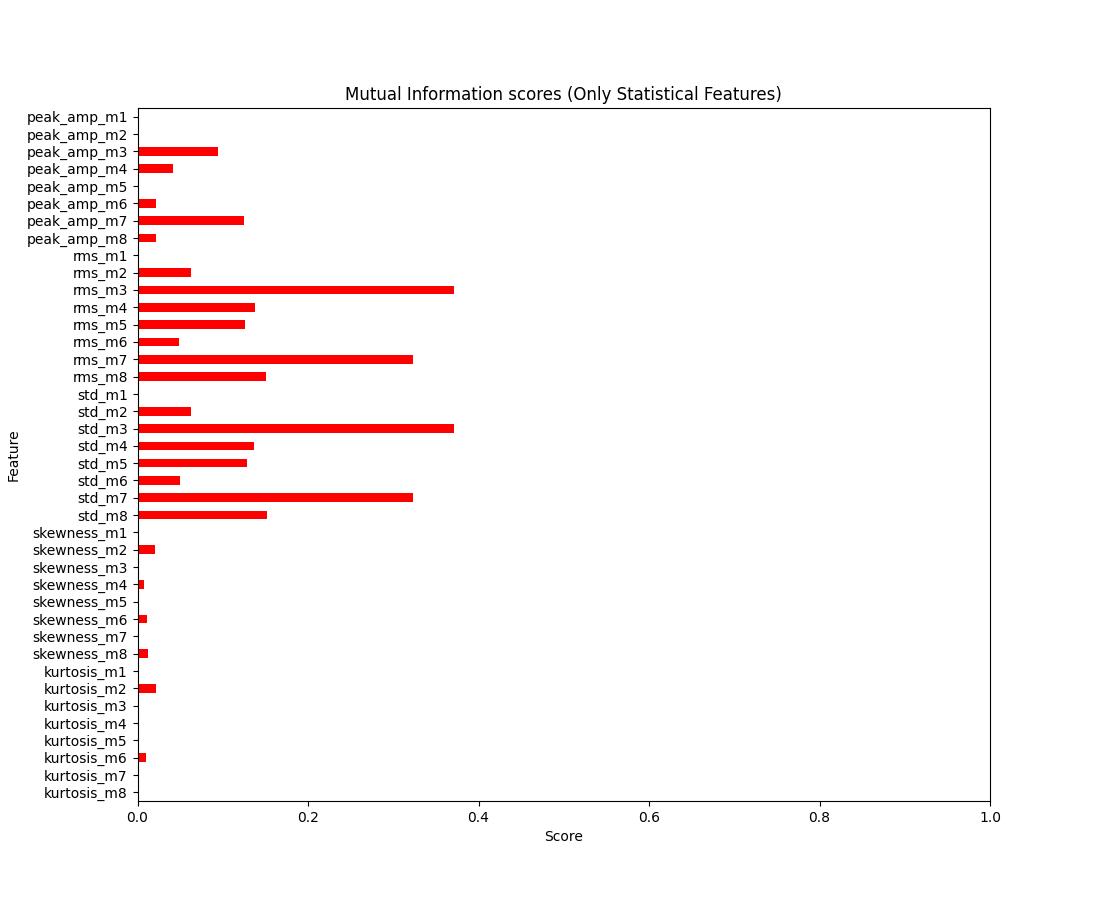

In [28]:
# Information Gain

from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_stat, y_stat)
mutual_info_df = pd.Series(mutual_info, index=X_stat.columns)
infogain_fig = plt.figure(figsize=(11,9))
infogain_plot = mutual_info_df.iloc[::-1].plot(kind="barh", color="red")
infogain_plot.set_xlabel("Score")
infogain_plot.set_ylabel("Feature")
infogain_plot.set_title("Mutual Information scores (Only Statistical Features)")
infogain_plot.set_xlim(0.0, 1.0)
plt.savefig("plots/mi_stat.svg")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_stat_train, X_stat_test, y_stat_train, y_stat_test = train_test_split(X_stat, y_stat, test_size=0.3, shuffle=False)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.98      0.98      0.98       120

    accuracy                           0.97       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.97      0.97      0.97       150



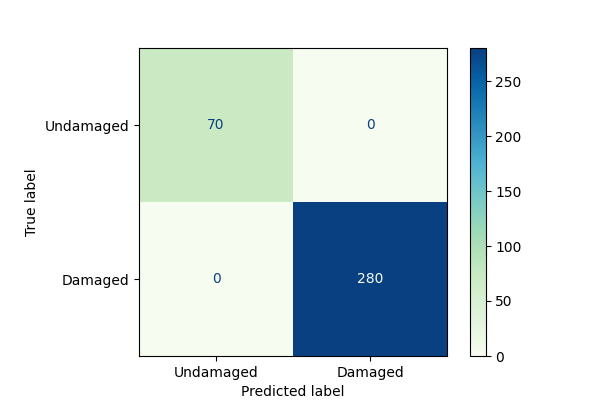

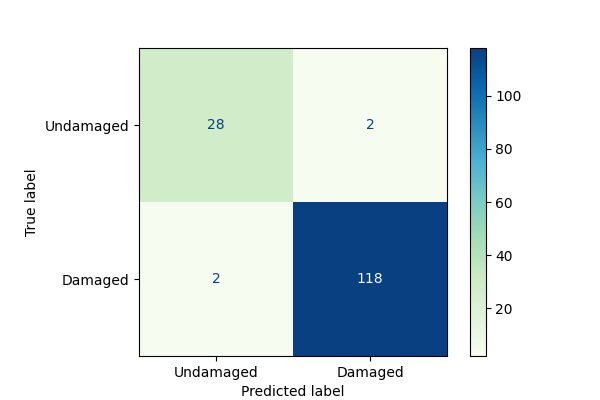

In [26]:
# SVM (all statistical features)

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
'''
C = np.arange(1, 1001, 1)
accuracy = []
for c in C:
    classif_stat = SVC(kernel='linear', gamma='scale', C=c)
    classif_stat.fit(X_stat_train, y_stat_train)
    y_stat_pred = classif_stat.predict(X_stat_test)
    accuracy.append(accuracy_score(y_stat_test, y_stat_pred))
CvsAcc1 = plt.figure(figsize=(7,4))
CvsAcc1plot = CvsAcc1.add_subplot(1,1,1)
CvsAcc1plot.plot(C, accuracy)
CvsAcc1plot.set_xlim([1, 1000])
CvsAcc1plot.set_ylim([0, 1])
CvsAcc1plot.set_xlabel("Regularization parameter (C)")
CvsAcc1plot.set_ylabel("Accuracy")
plt.savefig("plots/c_vs_acc_1.svg")
'''
classifier_stat = SVC(kernel='linear', gamma='scale', C=1000)
classifier_stat.fit(X_stat_train, y_stat_train)
y_stat_predict = classifier_stat.predict(X_stat_test)

print(classification_report(y_stat_test, y_stat_predict))
confmatfig1, confmatax1 = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_stat_test, y_stat_predict, cmap='GnBu', display_labels=["Undamaged", "Damaged"], ax=confmatax1)
#confmatplot1.plot()
#plt.savefig("plots/conf_mat_1.svg")

y_stat_predict_train = classifier_stat.predict(X_stat_train)
confmatfig2, confmatax2 = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_stat_train, y_stat_predict_train, cmap='GnBu', display_labels=["Undamaged", "Damaged"], ax=confmatax2)

plt.show()


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.99      1.00      1.00       120

    accuracy                           0.99       150
   macro avg       1.00      0.98      0.99       150
weighted avg       0.99      0.99      0.99       150



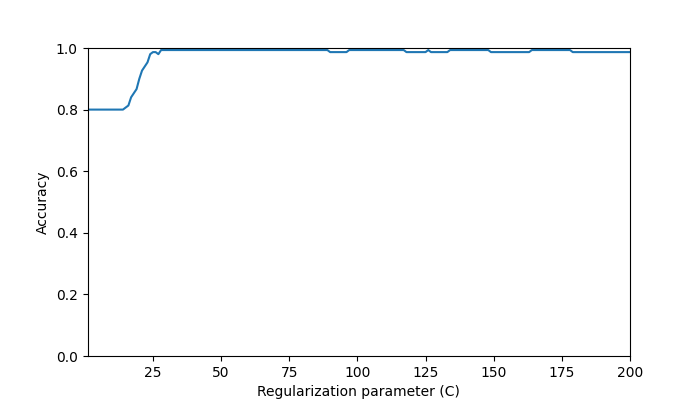

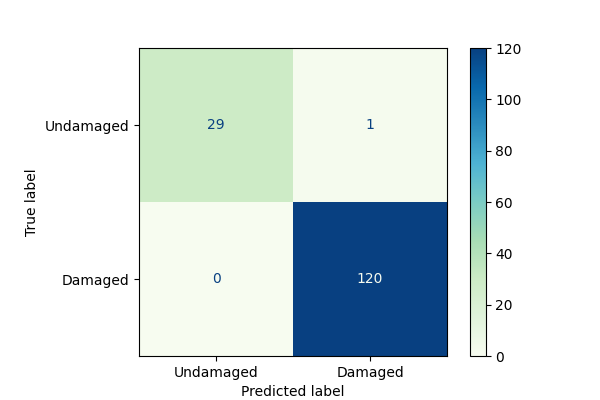

In [32]:
# SVM (selected statistical features)
X_statsel = X_stat[[f"rms_m{i+1}" for i in range(dofs)] + [f"std_m{i+1}" for i in range(dofs)]]

X_statsel_train, X_statsel_test, y_statsel_train, y_statsel_test = train_test_split(X_statsel, y_stat, test_size=0.3, shuffle=False)
C2 = np.arange(1, 201, 1)
accuracy2 = []
for c in C2:
    classif_stat = SVC(kernel='linear', gamma='scale', C=c)
    classif_stat.fit(X_statsel_train, y_statsel_train)
    y_statsel_pred = classif_stat.predict(X_statsel_test)
    accuracy2.append(accuracy_score(y_statsel_test, y_statsel_pred))
CvsAcc1 = plt.figure(figsize=(7,4))
CvsAcc1plot = CvsAcc1.add_subplot(1,1,1)
CvsAcc1plot.plot(C2, accuracy2)
CvsAcc1plot.set_xlim([1, 200])
CvsAcc1plot.set_ylim([0, 1])
CvsAcc1plot.set_xlabel("Regularization parameter (C)")
CvsAcc1plot.set_ylabel("Accuracy")
plt.savefig("plots/c_vs_acc_2.svg")

classifier_statsel = SVC(kernel='linear', gamma='scale', C=40)
classifier_statsel.fit(X_statsel_train, y_statsel_train)
y_statsel_predict = classifier_statsel.predict(X_statsel_test)

print(classification_report(y_statsel_test, y_statsel_predict))
confmatfig2, confmatax2 = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_statsel_test, y_statsel_predict, cmap="GnBu", display_labels=["Undamaged", "Damaged"], ax=confmatax2)
plt.savefig("plots/conf_mat_2.svg")

In [33]:
### Only ARX features

X_ARX = sigma_ratio_df.iloc[:,2:]
y_ARX = sigma_ratio_df['health']

In [ ]:
# Chi-squared

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ordered_rank_featuresARX = SelectKBest(score_func=chi2, k=8)
ordered_featuresARX = ordered_rank_featuresARX.fit(X_ARX, y_ARX)
scoreARX = pd.DataFrame(ordered_featuresARX.scores_, columns=["Score"])
scoreARX = pd.concat([pd.DataFrame(X_ARX.columns), scoreARX], axis = 1)
scoreARX = pd.Series(scoreARX["Score"].values, index=scoreARX[0].values)
chisq_plot = plt.figure(figsize=(11,9))
plot2 = scoreARX.iloc[::-1].plot(kind="barh", color="teal")
plot2.set_xlabel("Score")
plot2.set_ylabel("Feature")
plot2.set_title("Chi-square score")
plt.savefig("plots/chisqscore.svg")
plt.show()
scoreARX

In [ ]:
# Feature Importance

from sklearn.ensemble import ExtraTreesClassifier
modelARX = ExtraTreesClassifier()
modelARX.fit(X_ARX, y_ARX)
ranked_featuresARX = pd.Series(modelARX.feature_importances_, index=X_ARX.columns)
featureimparx_plot = plt.figure(figsize=(11,9))
featureimparx_ax = ranked_featuresARX.iloc[::-1].plot(kind='barh', color="teal")
featureimparx_ax.set_xlabel("Score")
featureimparx_ax.set_ylabel("Feature")
featureimparx_ax.set_title("Feature Importance (Only ARX Model Features)")
plt.savefig("fi_arx.svg")
plt.show()

In [ ]:
# Pearson's Correlation

import seaborn as sns

corr_dfARX = pd.concat([y_ARX, X_ARX], axis = 1)
corr_dfARX = corr_dfARX.corr()
plot3 = plt.figure(figsize=(12,10))
plotaxcorr = sns.heatmap(corr_dfARX[corr_dfARX.index].corr(), annot=True)
plotaxcorr.set_title("Pearson's Correlation for ARX Model Features")
plt.savefig("plots/corr_arx.svg")


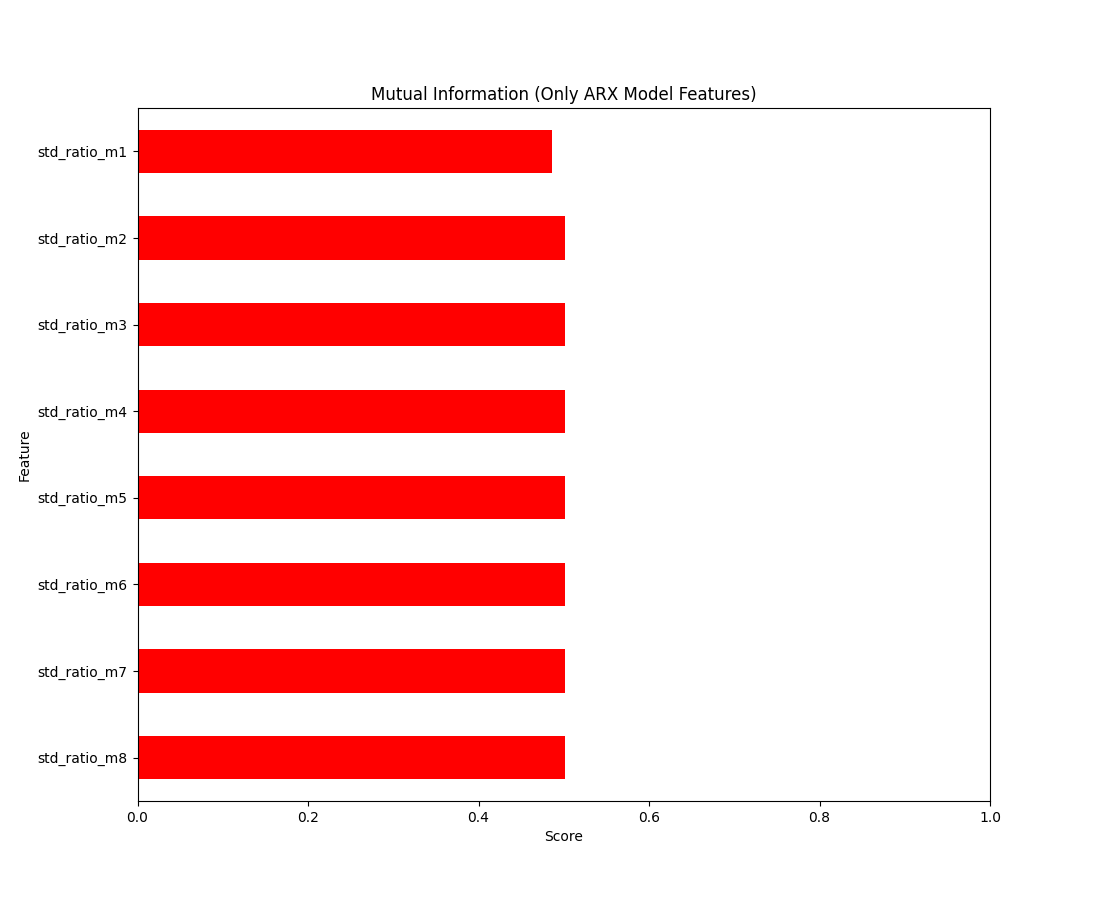

In [34]:
# Information Gain

from sklearn.feature_selection import mutual_info_classif

mutual_infoARX = mutual_info_classif(X_ARX, y_ARX)
mutual_info_dfARX = pd.Series(mutual_infoARX, index=X_ARX.columns)
mutinfoplot = plt.figure(figsize=(11,9))
mutinfoarx = mutual_info_dfARX.iloc[::-1].plot(kind="barh", color="red")
mutinfoarx.set_xlabel("Score")
mutinfoarx.set_ylabel("Feature")
mutinfoarx.set_title("Mutual Information (Only ARX Model Features)")
mutinfoarx.set_xlim(0.0,1.0)
plt.savefig("plots/mi_arx.svg")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       120

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



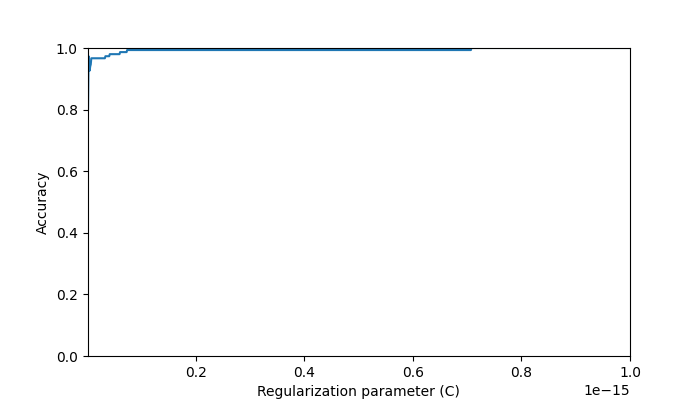

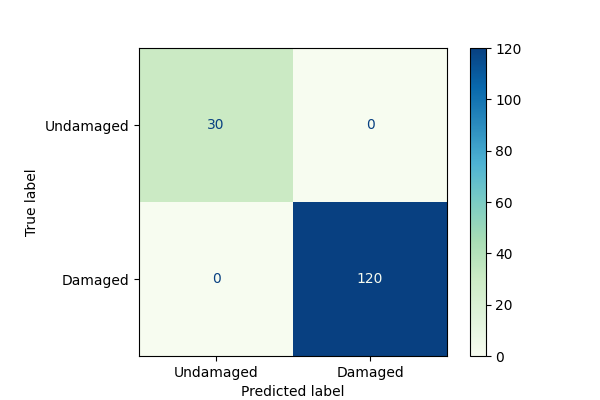

In [39]:
# SVM (ARX features)

X_ARX_train, X_ARX_test, y_ARX_train, y_ARX_test = train_test_split(X_ARX, y_ARX, test_size=0.3, shuffle=False)

C3 = np.arange(0.000000000000000001, 0.000000000000001, 0.000000000000000001)
accuracy3 = []
for c in C3:
    classif_stat = SVC(kernel='linear', gamma='scale', C=c)
    classif_stat.fit(X_ARX_train, y_ARX_train)
    y_ARX_pred = classif_stat.predict(X_ARX_test)
    accuracy3.append(accuracy_score(y_ARX_test, y_ARX_pred))
CvsAcc1 = plt.figure(figsize=(7,4))
CvsAcc1plot = CvsAcc1.add_subplot(1,1,1)
CvsAcc1plot.plot(C3, accuracy3)
CvsAcc1plot.set_xlim([0.000000000000000001, 0.000000000000001])
CvsAcc1plot.set_ylim([0, 1])
CvsAcc1plot.set_xlabel("Regularization parameter (C)")
CvsAcc1plot.set_ylabel("Accuracy")
plt.savefig("plots/c_vs_acc_3.svg")

classifier_ARX = SVC(kernel='linear', gamma='scale', C=0.000000000000001)
classifier_ARX.fit(X_ARX_train, y_ARX_train)
y_ARX_predict = classifier_ARX.predict(X_ARX_test)

print(classification_report(y_ARX_test, y_ARX_predict))
confmatfig3, confmatax3 = plt.subplots(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_ARX_test, y_ARX_predict, cmap="GnBu", display_labels=["Undamaged", "Damaged"], ax=confmatax3)
plt.savefig("plots/conf_mat_3.svg")


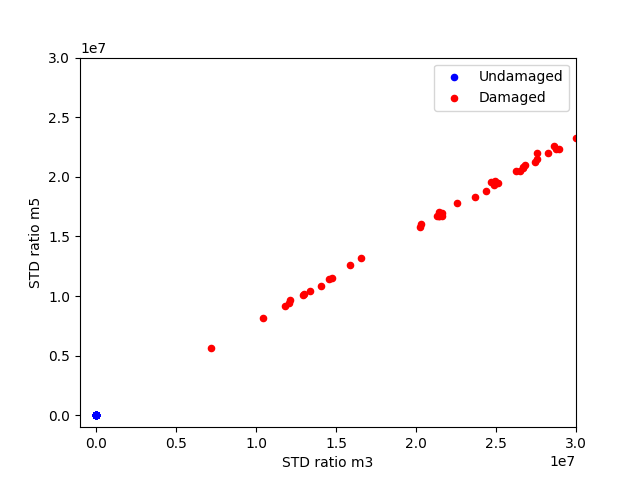

In [55]:
undamaged = sigma_ratio_df[sigma_ratio_df['health']==0]
damaged = sigma_ratio_df[sigma_ratio_df['health']==1]
axes = undamaged.plot(kind='scatter', x='std_ratio_m3', y='std_ratio_m5', color='blue', label='Undamaged')
damaged.plot(kind='scatter', x='std_ratio_m3', y='std_ratio_m5', color='red', label='Damaged', ax=axes)
axes.set_xlabel("STD ratio m3")
axes.set_ylabel("STD ratio m5")
axes.set_xlim([-1000000, 30000000])
axes.set_ylim([-1000000, 30000000])
plt.savefig("plots/redblue.svg")

In [ ]:
#acc_plot = plt.figure()
#accax = acc_plot.add_subplot(1,1,1)
stat = statistical_features_df.iloc[15:20,:]
fig_a1 = plt.figure(figsize=(8, 4), constrained_layout=True)
#fig_a1.suptitle(f"State #{j}")
#fig_a1.supxlabel("Time (sec)")
#fig_a1.supylabel("Displacement (m)")
plott = fig_a1.add_subplot(1,1,1)
for i in range(8):
    plott.plot([0,1,2,3,4], stat[f"skewness_m{i+1}"].values, label = "DOF-" + str(i+1), linewidth = 0.6, marker = 'x')
    plott.set_xlabel("State #")
    plott.set_ylabel("Skewness")
    plott.set_xticks([0,1,2,3,4])
    plott.grid(True)
plott.legend(loc = "upper right")
plt.savefig(f"skewness.svg")
#plt.savefig("force.svg")
plt.show()


In [31]:
# all combined

allfeatures_df = pd.concat([statistical_features_df, sigma_ratio_df.iloc[:,2:]], axis=1)
allfeatures_df

,health,state,peak_amp_m1,peak_amp_m2,peak_amp_m3,peak_amp_m4,peak_amp_m5,peak_amp_m6,peak_amp_m7,peak_amp_m8,...,kurtosis_m7,kurtosis_m8,std_ratio_m1,std_ratio_m2,std_ratio_m3,std_ratio_m4,std_ratio_m5,std_ratio_m6,std_ratio_m7,std_ratio_m8
0,0,0,9.427074,2.527748,2.431272,1.909595,1.662140,1.979266,1.416556,2.012263,...,0.049400,0.029662,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,1,1,9.583085,2.545184,2.520757,1.884971,1.680055,1.965768,1.386386,1.960155,...,0.055705,0.032481,0.999938,2.445913e+05,1.179645e+07,1.172317e+07,9.142867e+06,9.144117e+06,1.482079e+05,1.883734e+05
2,1,2,9.795297,2.509352,2.602306,1.922110,1.684153,1.928712,1.347756,1.939176,...,0.055926,0.036188,1.000313,5.072071e+05,2.435747e+07,2.420270e+07,1.881140e+07,1.881193e+07,3.068656e+05,3.911806e+05
3,1,3,10.235491,2.323097,2.700612,1.861925,1.696922,1.851604,1.296442,1.837733,...,0.043403,0.029727,1.001116,1.095160e+06,5.176257e+07,5.141425e+07,3.919003e+07,3.917973e+07,6.585924e+05,8.470544e+05
4,1,4,9.698867,2.393721,2.893516,1.456612,1.664604,1.719050,1.051316,1.605607,...,0.056737,-0.002049,1.011139,3.613379e+06,1.495793e+08,1.483367e+08,9.313252e+07,9.289210e+07,2.087417e+06,2.822641e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,8.723724,2.297489,2.157489,1.805002,1.768552,1.592690,1.491516,2.046714,...,-0.027863,-0.087057,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
496,1,1,8.700144,2.326655,2.193335,1.772652,1.760466,1.646119,1.451150,1.936261,...,-0.042381,-0.084066,1.000076,5.019404e+05,2.488265e+07,2.485518e+07,1.942958e+07,1.937312e+07,3.088604e+05,3.947864e+05
497,1,2,8.664976,2.351064,2.199205,1.802652,1.784881,1.695908,1.381461,1.852069,...,-0.057808,-0.080314,0.999792,1.040356e+06,5.105399e+07,5.098950e+07,3.965130e+07,3.953339e+07,6.386284e+05,8.196119e+05
498,1,3,8.623577,2.494129,2.195799,1.844880,1.821551,1.771215,1.271140,1.967113,...,-0.069089,-0.070103,0.999762,2.244805e+06,1.074872e+08,1.073071e+08,8.171128e+07,8.144689e+07,1.367942e+06,1.774137e+06


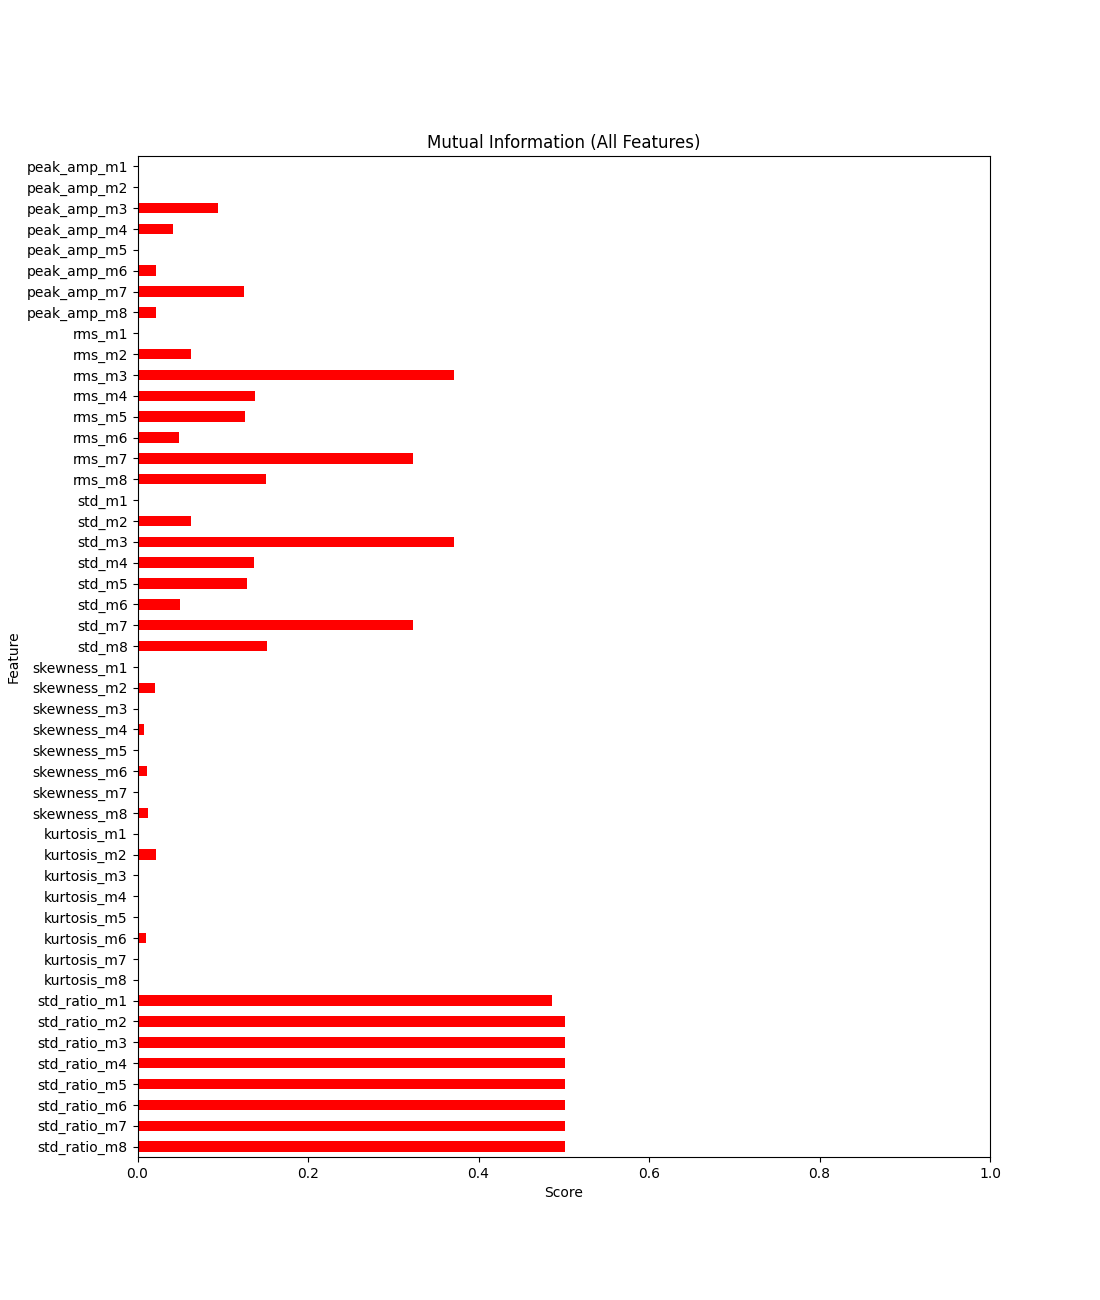

In [33]:
X_all = allfeatures_df.iloc[:,2:]
y_all = allfeatures_df["health"]

mutual_infoall = mutual_info_classif(X_all, y_all)
mutual_info_dfall = pd.Series(mutual_infoall, index=X_all.columns)
mutinfoplotall = plt.figure(figsize=(11,13))
mutinfoall = mutual_info_dfall.iloc[::-1].plot(kind="barh", color="red")
mutinfoall.set_xlabel("Score")
mutinfoall.set_ylabel("Feature")
mutinfoall.set_title("Mutual Information (All Features)")
mutinfoall.set_xlim(0.0,1.0)
plt.savefig("plots/mi_all.svg")
plt.show()